In [1]:
import matplotlib.pyplot as plt
import numpy as np

# from hazma.scalar_mediator import ScalarMediator

colors = 2*[c["color"] for c in plt.rcParams["axes.prop_cycle"]]

In [2]:
gsxx = 1.0
gsff = 1.0
gsGG = 1.0
gsFF = 1.0
ms = 1.0

## Integrating an interp1d

In [3]:
from scipy.integrate import quad
from scipy.interpolate import interp1d, InterpolatedUnivariateSpline
import numba
from numba import jit
from numba import cfunc
import timeit

In [17]:
cfunc("float64(float64, CPointer(float64), CPointer(float64), float64, float64, float64)")(np.interp)

TypingError: Failed at nopython (nopython frontend)
Untyped global name 'compiled_interp_complex': cannot determine Numba type of <type 'builtin_function_or_method'>

File "../../../../../.pyenv/versions/2.7.13/Python.framework/Versions/2.7/lib/python2.7/site-packages/numpy/lib/function_base.py", line 2049:
def interp(x, xp, fp, left=None, right=None, period=None):
    <source elided>
    if np.iscomplexobj(fp):
        interp_func = compiled_interp_complex
        ^


In [4]:
xs = np.arange(1, 101)
ys = np.exp(-xs) / xs**2
interp = InterpolatedUnivariateSpline(xs, ys)

def integrand(x):
    return np.interp(x, xs, ys)

nb_integrand = cfunc("float64(float64)")(integrand)

TypingError: Failed at nopython (nopython frontend)
Unknown attribute 'interp' of type Module(<module 'numpy' from '/Users/acoogan/.pyenv/versions/2.7.13/Python.framework/Versions/2.7/lib/python2.7/site-packages/numpy/__init__.pyc'>)

File "<ipython-input-4-88fa67fb4ea4>", line 6:
def integrand(x):
    return np.interp(x, xs, ys)
    ^

[1] During: typing of get attribute at <ipython-input-4-88fa67fb4ea4> (6)

File "<ipython-input-4-88fa67fb4ea4>", line 6:
def integrand(x):
    return np.interp(x, xs, ys)
    ^


In [78]:
def do_integrate(func):
    return quad(func, 0, 100)[0]

In [79]:
%timeit do_integrate(integrand)

100 loops, best of 3: 5.4 ms per loop


In [80]:
%timeit do_integrate(nb_integrand.ctypes)

1000 loops, best of 3: 1.29 ms per loop


In [22]:
%load_ext Cython

In [50]:
%%cython
cdef int add(int x, int y):
    return x + y

cdef Cget_decr():
    return lambda x: add(x, -1)

def get_decr():
    return Cget_decr

In [53]:
decr = get_decr()

for i in range(10000):
    decr(10)

TypeError: wrap() takes no arguments (1 given)

## Numba-compatible interpolator

In [54]:
xs = np.arange(1, 101)
ys = np.exp(-xs) / xs**2

In [ ]:
@jit
def nb_interp(x, xs, ys):
    return np.searchsorted(x, xs)

In [59]:
np.searchsorted(xs, 21.5)

21

## Convolving with energy resolution

In [3]:
from hazma.gamma_ray_limits.experiment_parameters import A_eff_e_astrogam

ImportError: cannot import name A_eff_e_astrogam

In [8]:
from hazma.gamma_ray_limits.gamma_ray_limit_parameters import energy_res_egret
from hazma.gamma_ray_limits.compute_limits import get_detected_spectrum
from scipy.interpolate import interp1d

In [5]:
# Monochromatic spectrum
line_es = np.array([9.9, 40.])
line_bfs = np.ones(line_es.shape)

# Continuum spectrum
sm = ScalarMediator(50., ms, gsxx, gsff, gsGG, gsFF)
e_gams = np.logspace(0, np.log10(sm.mx)+3, 300)
dndes = sm.spectra(e_gams, 2. * ex(sm.mx))["total"]

# Detected spectrum
dndes_det = get_detected_spectrum(e_gams, dndes, line_es=np.array([sm.mx]), line_bfs=np.array([2.]), energy_res=energy_res_egret)

ValueError: A value in x_new is below the interpolation range.

In [21]:
def get_detected_spectrum(e_gams, dndes, line_es, line_bfs, energy_res):
    # Standard deviation of spectra resolution function
    def sigma_srf(e):
        return e*energy_res(e)

    # Get the spectral resolution function
    def spec_res_fn(ep, e):
        sigma = sigma_srf(e)

        if sigma == 0:
            return np.zeros(ep.shape)
        else:
            return norm.pdf(ep, loc=e, scale=sigma)

    # Source spectrum function
    dnde_src = interp1d(e_gams, dndes)

    # Due to numerical limitations, the convolution must be performed in a
    # window of n_std standard deviations around the mean of the spectral
    # resolution function. N(5; 0, 1) / N(0;, 0, 1) ~ 6e-6, which seems to be
    # a good compromise between accuracy and speed.
    n_std = 6.

    print([(max(e_gams[0], e-n_std*sigma_srf(e)), min(e_gams[-1], e+n_std*sigma_srf(e))) for e in e_gams])

    # Continuum contribution to detected spectrum
    dndes_cont_det = np.array([quad(lambda ep: dnde_src(ep) *
                                    spec_res_fn(ep, e),
                                    max(e_gams[0], e-n_std*sigma_srf(e)),
                                    min(e_gams[-1], e-n_std*sigma_srf(e)))[0]
                               for e in e_gams])

    # Line contribution
    dndes_line_det = np.array([spec_res_fn(e_gams, e) * bf for
                               e, bf in zip(line_es, line_bfs)]).sum(axis=0)

    return interp1d(e_gams, dndes_cont_det + dndes_line_det)

In [9]:
def spec_res_fn(e, energy_res=energy_res_egret):
    eps = energy_res(e)
    
    if eps == 0.:
        return np.zeros(e_gams.shape)
    else:
        srf = np.exp(-(e_gams - e)**2 / (2. * (eps * e)**2))
        return srf / srf.sum()

from scipy.integrate import quad
from scipy.interpolate import interp1d
from scipy.stats import norm

def get_dndes_det(e_gams, dndes, energy_res=energy_res_egret):
    dnde_interp = interp1d(e_gams, dndes)
    
    return np.array([quad(lambda ep: dnde_interp(ep) * norm.pdf(ep, loc=e, scale=e*energy_res(e)),  # e_gams[0], e_gams[-1])[0] for e in e_gams])
                          max(e_gams[0], e - 3*e*energy_res(e)),
                          min(e_gams[-1], e + 3*e*energy_res(e)))[0] for e in e_gams])

In [11]:
line_es = np.array([5., 10.])
line_bfs = np.array([0.5, 2.])

dnde_line_det = np.array([norm.pdf(e_gams, e, e*energy_res_egret(e)) * bf
                          for e, bf in zip(line_es, line_bfs)])

In [12]:
dndes_det = dnde_line_det.sum(axis=0) + get_dndes_det(e_gams, dndes, energy_res_egret)

/Users/acoogan/.pyenv/versions/2.7.13/Python.framework/Versions/2.7/lib/python2.7/site-packages/scipy/integrate/quadpack.py:364: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  warnings.warn(msg, IntegrationWarning)
/Users/acoogan/.pyenv/versions/2.7.13/Python.framework/Versions/2.7/lib/python2.7/site-packages/scipy/integrate/quadpack.py:364: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  warnings.warn(msg, IntegrationWarning)
/Users/acoogan/.pyenv/versions/2.7.13

In [207]:
norm.pdf(3) / norm.pdf(1)

0.018315638888734182

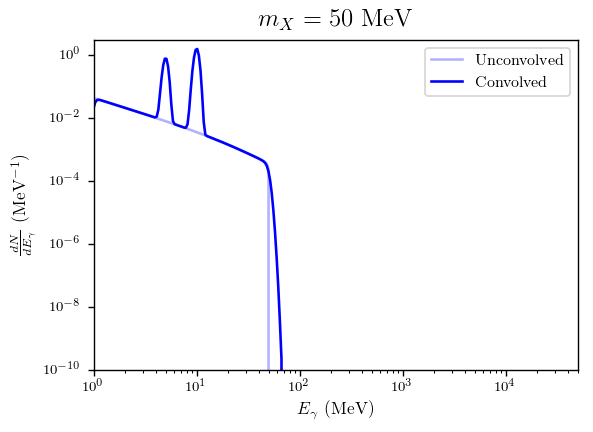

In [203]:
plt.plot(e_gams, dndes, 'b', label="Unconvolved", alpha=0.3)
plt.plot(e_gams, dndes_det, 'b', label="Convolved")

plt.xscale("log")
plt.yscale("log")
plt.xlim(e_gams[[0, -1]])
plt.ylim([1e-10, 3e0])
plt.title(r"$m_X = %.0f$ MeV" % sm.mx)
plt.xlabel(r"$E_\gamma$ (MeV)")
plt.ylabel(r"$\frac{dN}{dE_\gamma}$ (MeV$^{-1}$)")
plt.legend()